In [1]:
from IPython.display import display
from dataclasses import dataclass
import datetime
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.options.display.max_columns = None

from elarb.policy import (
    create_policy_input, optimal_policy, PolicyInput, PolicyOutput
)
from elarb.models import (
    SolarPanel,
    Battery,
    GridConnection,
    Inverter,
    Facility,
)
from elarb import datasets

## Load data

In [2]:
BIGNUM = 1000

df_nordpool = pd.read_csv('../data/nordpool_21_22.csv', parse_dates=['HourUTC', 'HourDK', 'Date'])
df_pv = (
    pd.read_csv('../data/pvwatts.csv')
    .loc[:, ['Month', 'Day', 'Hour', 'DC Array Output (W)']]
)
df = df_nordpool.copy()
df['Month'] = df.HourDK.dt.month
df['Day'] = df.HourDK.dt.day
df = (
    df.merge(df_pv, on=['Month', 'Day', 'Hour'])
    .drop(columns=['HourUTC', 'SpotPriceEUR', 'Date', 'Hour', 'Month', 'Day'])
    .drop_duplicates()
    .sort_values(by='HourDK')
    .rename(columns={
        'DC Array Output (W)': 'pv_dc_kWh_m2',
        'HourDK': 'ts',
        'PriceArea': 'price_area',
        'SpotPriceDKK': 'spot_price',
    })
    .reset_index(drop=True)
    .set_index('ts')
)
df['net_tariff'] = 0.8
df['spot_demand_kWh'] = BIGNUM
df['spot_supply_kWh'] = BIGNUM
df['spot_price'] /= 1000
df['pv_dc_kWh_m2'] /= 1000
df[df['pv_dc_kWh_m2']>0]

,price_area,spot_price,pv_dc_kWh_m2,net_tariff,spot_demand_kWh,spot_supply_kWh
ts,,,,,,
2021-01-01 09:00:00,DK2,0.33395,0.0084,0.8,1000,1000
2021-01-01 10:00:00,DK2,0.33485,0.0838,0.8,1000,1000
2021-01-01 11:00:00,DK2,0.35122,0.2444,0.8,1000,1000
2021-01-01 12:00:00,DK2,0.37785,0.3716,0.8,1000,1000
2021-01-01 13:00:00,DK2,0.33849,0.2650,0.8,1000,1000
...,...,...,...,...,...,...
2022-10-17 12:00:00,DK2,0.87383,0.1801,0.8,1000,1000
2022-10-17 13:00:00,DK2,0.87494,0.1751,0.8,1000,1000
2022-10-17 14:00:00,DK2,0.91682,0.1532,0.8,1000,1000


<AxesSubplot: >

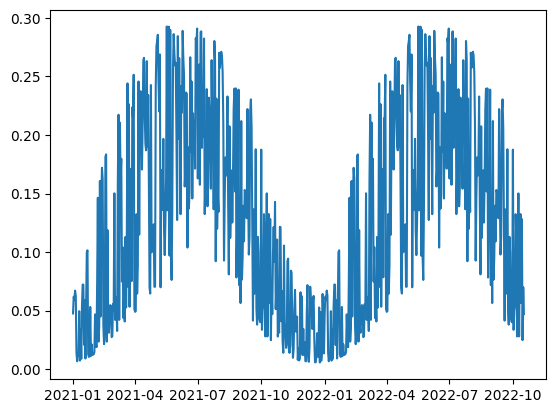

In [3]:
df.groupby(df.index.date).pv_dc_kWh_m2.mean().plot()

In [4]:
df['2022-10-17 13:00:00': '2022-10-17 16:00:00']

,price_area,spot_price,pv_dc_kWh_m2,net_tariff,spot_demand_kWh,spot_supply_kWh
ts,,,,,,
2022-10-17 13:00:00,DK2,0.87494,0.1751,0.8,1000,1000
2022-10-17 14:00:00,DK2,0.91682,0.1532,0.8,1000,1000
2022-10-17 15:00:00,DK2,1.03663,0.0734,0.8,1000,1000
2022-10-17 16:00:00,DK2,1.26221,0.0159,0.8,1000,1000


In [5]:
datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
#datetime.strptime(, format)

'2023-01-06 02:22:45'

## Configure and optimise

In [6]:
n_panels = widgets.IntSlider(value=100, min=0, max=200, description='Solar panels:', continuous_update=True)
n_inverters = widgets.IntSlider(value=3, min=0, max=10, description='Inverters:', continuous_update=True)
n_batteries = widgets.IntSlider(value=9, min=0, max=10, description='Batteries:', continuous_update=True)
stikledning_amp = widgets.IntSlider(value=63.0, min=0, max=100, description='Ampere:', continuous_update=True)
stikledning_volt = widgets.IntSlider(value=400, min=0, max=500, description='Volt:', continuous_update=True)

In [7]:
display(n_panels)
display(n_inverters)
display(n_batteries)
display(stikledning_amp)
display(stikledning_volt)

IntSlider(value=100, description='Solar panels:', max=200)

IntSlider(value=3, description='Inverters:', max=10)

IntSlider(value=9, description='Batteries:', max=10)

IntSlider(value=63, description='Ampere:')

IntSlider(value=400, description='Volt:', max=500)

## Configuration

In [8]:
# solar panels: 470Wp JinKO TigerNeo N-Type 60HL4 BF, 1.57 kWh / time, costs 1565 DKK
panel = SolarPanel(m2=0.75, depreciation_per_hour=0.0059)
# DK grid
grid = GridConnection(throughput_kWh=stikledning_amp.value * stikledning_volt.value / 1000)
# Deye SUN-12K-SG04LP3-EU
inverter = Inverter(depreciation_per_hour=0.0, throughput_kWh=15.6, conversion_loss_pct=0.03,)
# battery: Powerwall LBATTS Powerwall, 8.8 kwh
battery = Battery(depreciation_per_kWh=0.398, throughput_kWh=3.3, capacity_kWh=8.8, conversion_loss_pct=0.03,)
facility = Facility(
    panel=panel,
    grid=grid,
    inverter=inverter,
    battery=battery,
    n_panels=n_panels.value,
    n_inverters=n_inverters.value,
    n_batteries=n_batteries.value
)
print(facility)

Facility(panel=SolarPanel(m2=0.75, depreciation_per_hour=0.0059), battery=Battery(capacity_kWh=8.8, throughput_kWh=3.3, conversion_loss_pct=0.03, depreciation_per_kWh=0.398), inverter=Inverter(throughput_kWh=15.6, depreciation_per_hour=0.0, conversion_loss_pct=0.03), grid=GridConnection(throughput_kWh=25.2), n_panels=100, n_batteries=9, n_inverters=3)


In [9]:
class Simulator:
    def __init__(self, facility, periods, initial_soc=0.0):
        self.periods = periods
        self.facility = facility
        self.initial_soc=initial_soc
    
    def simulate_policy(self, policy):
        soc = self.initial_soc
        for period in self.periods:
            policy_in = create_policy_input(facility=self.facility, df=period, initial_soc=soc)
            outcome = policy(policy_in)
            yield outcome
            soc = outcome.battery_soc_kWh[-1]
            

In [10]:
tss = [(t0, t0 + datetime.timedelta(days=1)) for t0 in df[df.index.hour == 12].index]
periods = [df[t0:t1] for t0, t1 in tss]

simulator = Simulator(facility, periods)

outcomes = list(simulator.simulate_policy(policy=optimal_policy))

In [11]:
df_outcomes = (
    pd.DataFrame({
        'year': [ts0.year for (ts0, _) in tss],    
        'year_month': [f'{ts0.year}_{ts0.month}' for (ts0, _) in tss],
        'start_ts': [ts0 for (ts0, _) in tss],
        'dkk': [o.value for o in outcomes],
        'dkk_x1': [o.x1_contrib for o in outcomes],
        'dkk_x3': [o.x3_contrib for o in outcomes],
        'kWh': [
            o.x1.sum() + o.x2.sum() + o.x3.sum() + o.x4.sum()
            for o in outcomes
        ],
        'kWh_x1': [o.x1.sum() for o in outcomes],
        'kWh_x2': [o.x2.sum() for o in outcomes],
        'kWh_x3': [o.x3.sum() for o in outcomes],
        'kWh_x4': [o.x4.sum() for o in outcomes],
        'spot_price_min': [o.spot_price.min() for o in periods],
        'spot_price_max': [o.spot_price.max() for o in periods],
        'spot_price_mean': [o.spot_price.mean() for o in periods],
        'spot_price_std': [o.spot_price.std() for o in periods],
        'pv_kWh_min': [o.pv_dc_kWh_m2.min() for o in periods],
        'pv_kWh_max': [o.pv_dc_kWh_m2.max() for o in periods],
        'pv_kWh_mean': [o.pv_dc_kWh_m2.mean() for o in periods],
        'pv_kWh_std': [o.pv_dc_kWh_m2.std() for o in periods],
    })
    .set_index('start_ts')
)
df_outcomes

,year,year_month,dkk,dkk_x1,dkk_x3,kWh,kWh_x1,kWh_x2,kWh_x3,kWh_x4,spot_price_min,spot_price_max,spot_price_mean,spot_price_std,pv_kWh_min,pv_kWh_max,pv_kWh_mean,pv_kWh_std
start_ts,,,,,,,,,,,,,,,,,,
2021-01-01 12:00:00,2021,2021_1,-14.750000,0.000000e+00,0.000000e+00,32.537573,0.000000e+00,32.537573,0.000000e+00,0.000000e+00,0.27941,0.45100,0.366276,0.050901,0.0,0.4077,0.071208,0.133167
2021-01-02 12:00:00,2021,2021_1,-14.750000,-2.046714e-11,-2.267680e-13,16.682109,3.791675e-11,16.682109,5.823555e-13,0.000000e+00,0.17747,0.46938,0.316067,0.111083,0.0,0.4077,0.075872,0.141973
2021-01-03 12:00:00,2021,2021_1,-14.750000,-3.542633e-13,-7.055783e-16,14.126783,8.414549e-13,14.126783,1.914496e-15,0.000000e+00,0.17769,0.43359,0.257498,0.096440,0.0,0.4097,0.076188,0.142506
2021-01-04 12:00:00,2021,2021_1,-14.750000,-2.379118e-11,-6.268686e-12,10.688885,6.687350e-11,10.688885,1.675168e-11,1.446395e-12,0.20142,0.48530,0.346915,0.110987,0.0,0.3934,0.077560,0.138088
2021-01-05 12:00:00,2021,2021_1,-14.750000,-1.591821e-11,-2.907316e-12,5.315317,3.784288e-11,5.315317,8.625101e-12,0.000000e+00,0.20812,0.48793,0.324680,0.103563,0.0,0.3382,0.041572,0.094082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-13 12:00:00,2022,2022_10,247.538080,1.781428e+02,1.069469e+02,255.301938,1.189500e+02,79.061313,5.729063e+01,1.526768e-11,1.50322,3.06932,2.010864,0.379752,0.0,0.5372,0.120808,0.186074
2022-10-14 12:00:00,2022,2022_10,119.045079,8.371613e+01,7.013815e+01,184.845000,9.747869e+01,36.966311,5.040000e+01,0.000000e+00,0.99188,2.22622,1.521728,0.377479,0.0,0.5372,0.071704,0.139267
2022-10-15 12:00:00,2022,2022_10,-9.926268,3.290774e+00,4.419722e+00,57.477543,1.321500e+01,37.009368,7.253175e+00,0.000000e+00,0.11341,1.40935,0.664497,0.447752,0.0,0.2955,0.056948,0.097157


In [12]:
df_outcomes.groupby('year').dkk.sum()

year
2021     1457.550431
2022    67606.295634
Name: dkk, dtype: float64

In [13]:
df_outcomes.groupby('year').kWh.sum()

year
2021    18014.311231
2022    73853.276072
Name: kWh, dtype: float64

In [14]:
df_outcomes.groupby('year').kWh_x1.sum()

year
2021    10171.878025
2022    39200.000972
Name: kWh_x1, dtype: float64

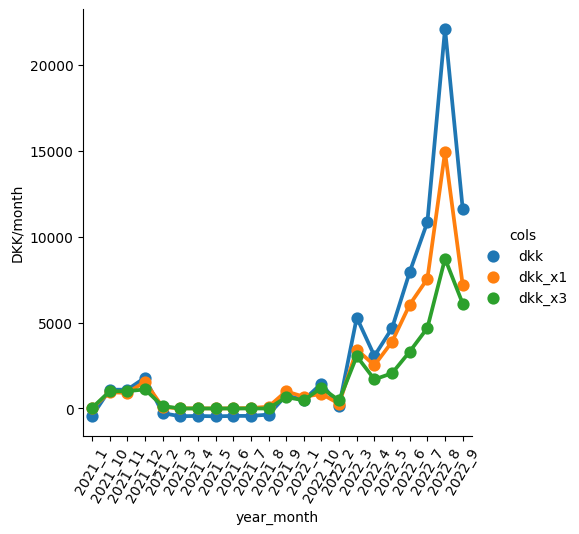

In [15]:
df_plot = (
    df_outcomes
    .loc[:, ['year_month', 'dkk', 'dkk_x1', 'dkk_x3']]
    .groupby('year_month')
    .sum()
    .reset_index()
    .melt('year_month', var_name='cols', value_name='vals')
)
sns.catplot(x="year_month", y="vals", hue='cols', data=df_plot, kind='point')
plt.xticks(rotation=60)
plt.ylabel('DKK/month')
plt.show()

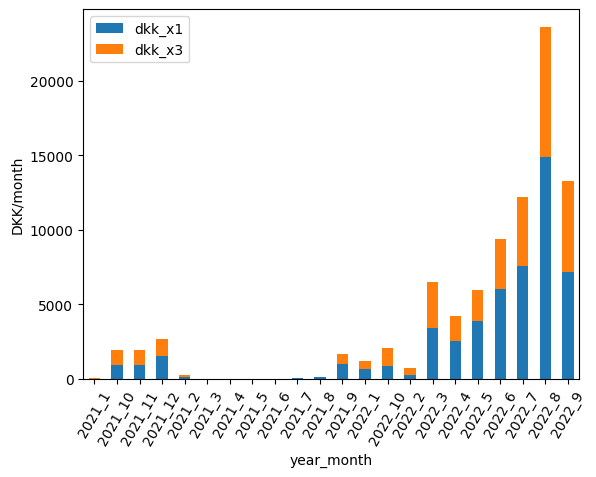

In [16]:
df_plot = (
    df_outcomes
    .loc[:, ['year_month', 'dkk_x1', 'dkk_x3']]
    .groupby('year_month')
    .sum()
)
df_plot.plot(kind='bar', stacked=True)
plt.xticks(rotation=60)
plt.ylabel('DKK/month')
plt.show()

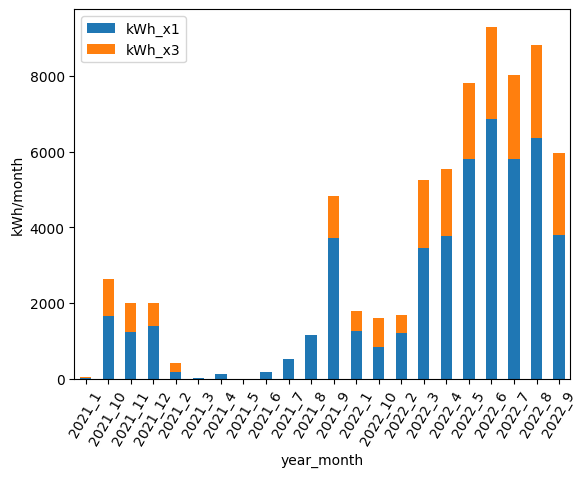

In [17]:
df_plot = (
    df_outcomes
    .loc[:, ['year_month', 'kWh_x1', 'kWh_x3']]
    .groupby('year_month')
    .sum()
)
df_plot.plot(kind='bar', stacked=True)
plt.xticks(rotation=60)
plt.ylabel('kWh/month')
plt.show()

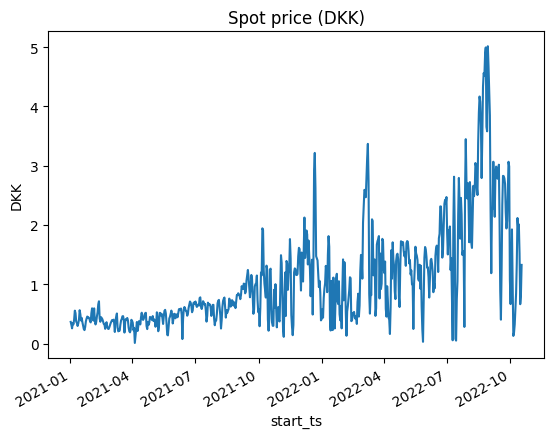

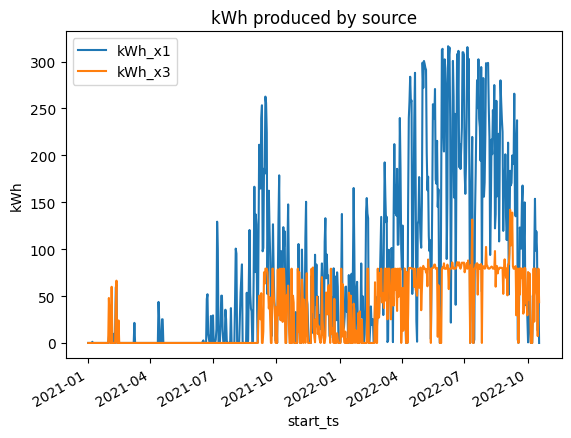

In [18]:
df_plot = (
    df_outcomes.spot_price_mean
)
df_plot.plot()
plt.title('Spot price (DKK)')
plt.ylabel('DKK')
plt.show()

df_plot = (
    df_outcomes.loc[:, ['kWh_x1', 'kWh_x3']]
)
df_plot.plot()
plt.title('kWh produced by source')
plt.ylabel('kWh')
plt.legend()
plt.show()

In [19]:
np.minimum([1,2,3,4,5], [5,4,3,2,1])

array([1, 2, 3, 2, 1])

51001.0675


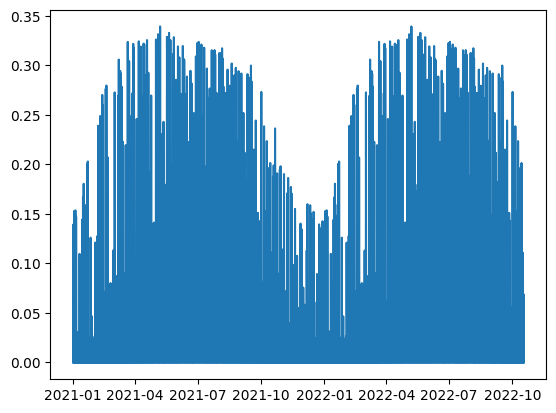

In [20]:
_pv = np.minimum(df.pv_dc_kWh_m2*panel.m2*0.5, panel.peak_kWh)
print(_pv.sum() * 120 / 1.8)
plt.plot(_pv)